***Credit Risk Prediction: A Machine Learning Analysis of Lending Club Loans***

A project by Anna Rakayev and Tamar Shemesh
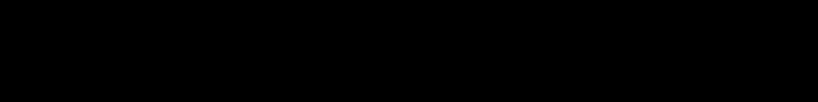
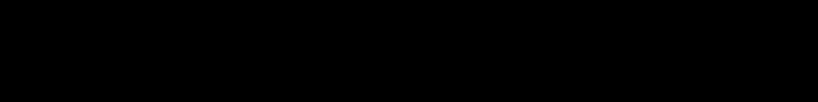

In [1]:
import pandas as pd

In [2]:
# loading the data
df = pd.read_csv("C:/Users/na270/OneDrive/drive/OneDrive/uni/4th/project/loan.csv")
df.shape

C:\Users\na270\AppData\Local\Temp\ipykernel_20436\3349856822.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/na270/OneDrive/drive/OneDrive/uni/4th/project/loan.csv")


(2260668, 145)

***Handling missing values***

In [3]:
# Calculate the percentage of missing values for each column
missing_percent = df.isnull().mean() * 100

# Put it into a table
missing_table = pd.DataFrame({
    'Column': df.columns,
    'Missing (%)': missing_percent.round(2)
}).sort_values(by='Missing (%)', ascending=False)

print(missing_table)

missing_percent_threshold = 30
high_missing_but_relevant = ['total_bal_il', 'max_bal_bc', 'emp_title'] # Columns with many missing values that we'll keep for now to evaluate their potential impact on model performance later.

                                                                                Column  \
id                                                                                  id   
url                                                                                url   
member_id                                                                    member_id   
orig_projected_additional_accrued_interest  orig_projected_additional_accrued_interest   
hardship_length                                                        hardship_length   
...                                                                                ...   
out_prncp                                                                    out_prncp   
initial_list_status                                                initial_list_status   
total_acc                                                                    total_acc   
delinq_amnt                                                                delinq_amnt   
addr_state

***Handling Correlation***

In [4]:
# --- Correlation check (numeric columns only) ---

# Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Compute absolute correlation matrix
corr = df[numeric_cols].corr().abs()

# Find highly correlated pairs (r > 0.9)
high_corr_pairs = [
    (c1, c2, corr.loc[c1, c2])
    for c1 in corr.columns
    for c2 in corr.columns
    if c1 != c2 and corr.loc[c1, c2] > 0.9
]

# Sort by correlation strength and show if > 0.9
high_corr_pairs = sorted(list(set(tuple(sorted(p[:2])) for p in high_corr_pairs)), key=lambda x: corr.loc[x[0], x[1]], reverse=True)
print("Highly correlated numeric column pairs (corr > 0.9):")
for c1, c2 in high_corr_pairs[:30]:
    print(f"{c1:30} ↔ {c2:30}  corr = {corr.loc[c1, c2]:.2f}")


Highly correlated numeric column pairs (corr > 0.9):
hardship_amount                ↔ orig_projected_additional_accrued_interest  corr = 1.00
out_prncp                      ↔ out_prncp_inv                   corr = 1.00
funded_amnt                    ↔ loan_amnt                       corr = 1.00
total_pymnt                    ↔ total_pymnt_inv                 corr = 1.00
funded_amnt                    ↔ funded_amnt_inv                 corr = 1.00
funded_amnt_inv                ↔ loan_amnt                       corr = 1.00
num_sats                       ↔ open_acc                        corr = 1.00
num_actv_rev_tl                ↔ num_rev_tl_bal_gt_0             corr = 0.98
tot_cur_bal                    ↔ tot_hi_cred_lim                 corr = 0.98
collection_recovery_fee        ↔ recoveries                      corr = 0.97
total_pymnt                    ↔ total_rec_prncp                 corr = 0.97
total_pymnt_inv                ↔ total_rec_prncp                 corr = 0.97
total_bal_i

In [9]:
# Columns that contain post-loan information 
leakage_columns = [
    'hardship_flag', 'debt_settlement_flag',
    'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'recoveries',
    'collection_recovery_fee', 'out_prncp', 'total_pymnt_inv', 'out_prncp_inv', 'grade', 'sub_grade', 'issue_d'
]


# Redundant or highly correlated features to remove
redundant_columns = [
    'funded_amnt', 'funded_amnt_inv', 'open_acc',
    'num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
    'total_il_high_credit_limit', 'installment',
    'total_bal_ex_mort', 'title', 'revol_bal', 'initial_list_status', 'last_credit_pull_d', 'policy_code','disbursement_method', 'total_rev_hi_lim'
]

high_missing_but_relevant = ['total_bal_il', 'max_bal_bc', 'emp_title'] # Columns with many missing values that we'll keep for now to evaluate their potential impact on model performance later.


In [6]:
STATUS_TO_TARGET = {
    "Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1,
    "Does not meet the credit policy. Status:Charged Off": 1,
}

In [12]:
# ---------- Cleaning function used inside the Pipeline ----------
def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    clean_df = df.copy()
    
    # Drop leakage + redundant 
    clean_df = clean_df.drop(columns=[c for c in leakage_columns + redundant_columns if c in df.columns])

    
    #remove all rows where verification_status is "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified'].reset_index(drop=True)
    clean_df = clean_df.drop(columns=['verification_status'])

    # Find which columns to drop: more than 30% missing and not in the exception list
    cols_to_drop = [col for col in df.columns 
                if (missing_percent[col] > missing_percent_threshold) and (col not in high_missing_but_relevant)]

    # Drop them
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Target mapping and row filtering
    clean_df['loan_status'] = df['loan_status'].map(STATUS_TO_TARGET)
    clean_df = clean_df[clean_df['loan_status'].notna()]    

    # Clean the 'term' column: keep only the number and convert to numeric
    clean_df['term'] = clean_df['term'].str.extract('(\d+)').astype(float)


    # Cleaning the empp_length
    # Handle "< 1 year" case (represents less than one)
    clean_df.loc[clean_df['emp_length'].str.contains('< 1', na=False), 'emp_length'] = 0

    # Remove unwanted characters and keep only digits
    clean_df['emp_length'] = (
        clean_df['emp_length']
        .str.extract('(\d+)')            # extract the number (e.g., "10" from "10+ years")
        .astype(float) )                  # convert to numeric
        
        
        
    return clean_df

In [13]:
# --- Apply the cleaning function ---
df_clean = basic_clean(df)

# --- Show the cleaned data ---
print("Shape after cleaning:", df_clean.shape)
display(df_clean.head(5))        
df_clean.info()                 # Structure after cleaning

Shape after cleaning: (761728, 57)


,loan_amnt,term,int_rate,emp_title,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,...,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit
100,7500,36.0,11.31,Supervisor,7.0,MORTGAGE,40500.0,0.0,n,debt_consolidation,...,23.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,27700.0
152,5000,36.0,10.72,sheet metal worker,10.0,RENT,50000.0,0.0,n,renewable_energy,...,10.0,0.0,0.0,0.0,0.0,100.0,83.3,0.0,0.0,16800.0
170,12000,60.0,12.98,NaN,NaN,RENT,55000.0,0.0,n,debt_consolidation,...,10.0,0.0,0.0,0.0,0.0,100.0,0.0,1.0,0.0,1500.0
186,20000,60.0,15.02,Teacher,4.0,MORTGAGE,65000.0,0.0,n,debt_consolidation,...,21.0,0.0,0.0,0.0,4.0,93.5,0.0,0.0,0.0,44700.0
215,10000,36.0,7.56,NaN,2.0,RENT,25000.0,0.0,n,debt_consolidation,...,5.0,0.0,0.0,0.0,2.0,85.7,100.0,0.0,0.0,11500.0


<class 'pandas.core.frame.DataFrame'>
Index: 761728 entries, 100 to 1515861
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   761728 non-null  int64  
 1   term                        761728 non-null  float64
 2   int_rate                    761728 non-null  float64
 3   emp_title                   707494 non-null  object 
 4   emp_length                  647356 non-null  float64
 5   home_ownership              761728 non-null  object 
 6   annual_inc                  761728 non-null  float64
 7   loan_status                 761728 non-null  float64
 8   pymnt_plan                  761728 non-null  object 
 9   purpose                     761728 non-null  object 
 10  zip_code                    761728 non-null  object 
 11  addr_state                  761728 non-null  object 
 12  dti                         761694 non-null  float64
 13  delinq_2yrs     

In [21]:
print(df_clean['purpose'].value_counts())

purpose
debt_consolidation    453580
credit_card           160136
home_improvement       46916
other                  44353
major_purchase         14484
small_business         10477
medical                 8457
car                     6619
moving                  5953
vacation                4895
house                   4175
wedding                 1013
renewable_energy         616
educational               54
Name: count, dtype: int64


In [17]:
df_clean.head(5)

,loan_amnt,term,int_rate,emp_title,emp_length,home_ownership,annual_inc,loan_status,pymnt_plan,purpose,...,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit
100,7500,36.0,11.31,Supervisor,7.0,MORTGAGE,40500.0,0.0,n,debt_consolidation,...,23.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,27700.0
152,5000,36.0,10.72,sheet metal worker,10.0,RENT,50000.0,0.0,n,renewable_energy,...,10.0,0.0,0.0,0.0,0.0,100.0,83.3,0.0,0.0,16800.0
170,12000,60.0,12.98,NaN,NaN,RENT,55000.0,0.0,n,debt_consolidation,...,10.0,0.0,0.0,0.0,0.0,100.0,0.0,1.0,0.0,1500.0
186,20000,60.0,15.02,Teacher,4.0,MORTGAGE,65000.0,0.0,n,debt_consolidation,...,21.0,0.0,0.0,0.0,4.0,93.5,0.0,0.0,0.0,44700.0
215,10000,36.0,7.56,NaN,2.0,RENT,25000.0,0.0,n,debt_consolidation,...,5.0,0.0,0.0,0.0,2.0,85.7,100.0,0.0,0.0,11500.0
